# Homework 5: What happens in Vegas, stays in Venmo ##


## Team: SouthAggies ##

## PART 1 ##

### Q1: We've added the following words to appropriate categories in the word classification dictionary ###

- People: maa
- Travel: santa cruz
- Transportation: cable car
- Utility: iron steamer, study chair
- Activity: go karting, swimming, trekking
- Food: cold stone, mushrooms

### Spark Installation ###

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null #Install java
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz ## Install Apache Spark
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

import os
from pyspark.sql import SparkSession

# Define Java and Spark home path in Google Colab
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()

# Initialize Spark session
spark = SparkSession.builder.appName("Venmo Transactions").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6a6e9eb4f6673e532b767ae6b6ef4f63455c950ede8f64763c3007c4a0f7d858
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


### Q2: Classifying Venmo’s transactions in the sample dataset ###

Procedure followed:

1. Loaded the emoji and word dictionaries.
2. Loaded the Venmo sample dataset.
3. Created the following utility functions:
- is_emoji Function: Checks if a character is an emoji using the 'emoji' library.
- classify_description Function: Classifies transactions as 'Text only', 'Emojis only', 'Both', or 'Uncategorized' based on their descriptions. Throughout, the emojis are identified using 'emoji' library or the emoji dictionary.
- categorize_content Function:
    - Categorizes descriptions into word and emoji categories using appropriate dictionaries.
    - 3 new columns were created to store the relevant data: word_categories, emoji_categories and all_categories.
    - all_categories is the combined set of word (word_categories) and emoji (emoji_categories) categories the each description falls into.
    - Any unmatched transactions fall under 'Uncategorized'.

4. % of emojis only transactions: (n_emojis_only_transactions/ n_total_Transactions) * 100
5. Top 5 most popular emojis: Extracted based on their use in 'Emojis Only' and combined texts. Each emoji per description, if any, was counted only once.
6. Top three most popular emoji categories: Extracted based on the frequency of each category in the emoji_categories column.



In [ ]:
# Install the emoji library
!pip install emoji

# Load necessary libraries
import pandas as pd
import re
import emoji
from collections import Counter
from pyspark.sql.functions import udf, col, explode, collect_list, struct, count, sum as sql_sum, months_between, min, ceil, to_date, avg, stddev, size
from pyspark.sql.types import StringType, ArrayType, IntegerType, StructType, StructField
import matplotlib.pyplot as plt
import numpy as np

# Load the word and emoji dictionaries
word_dict = pd.read_csv('/content/Venmo Word Classification Dictonary BAX-423 - Word_Dict.csv')
emoji_dict = pd.read_csv('/content/Venmo_Emoji_Classification_Dictionary.csv')

# Load the Venmo sample dataset
venmo_data = spark.read.parquet('/content/VenmoSample.snappy.parquet')

# Display the first few rows of each dataframe
print("Word Dictionary:")
print(word_dict.head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.1 MB/s eta 0:00:00
Word Dictionary:
       People       Food      Event Activity Travel Transportation  \
0      friend       food   birthday     ball  beach           lyft   
1  friendship        bbq  christmas     boat  place           uber   
2        baby       bean      happy      bar     la            cab   
3         boy      latte       bday     book  world            bus   
4        girl  breakfast    wedding     club  hotel            car   

       Utility   Cash Illegal/Sarcasm  @dropdown  
0         bill   atm        addiction        NaN  
1        cable  bank             drug        NaN  
2          fee  cash            wangs        NaN  
3     electric  money            weed        NaN  
4  electricity   buck            anal        NaN  


In [ ]:
print("Emoji Dictionary:")
print(emoji_dict.head())

Emoji Dictionary:
  Event Travel Food Activity Transportation People Utility
0    🇦🇺      🏔    🍇        👾              🚄      😀       ⚡
1    🇫🇷      ⛰    🍈        🕴              🚅      😃       💡
2     🎂      🌋    🍉        🎪              🚆      😄       🔌
3     🛍      🗻    🍊        🎭              🚇      😁       📺
4    🇨🇦      🏕    🍋        🎨              🚈      😆       🔌


In [ ]:
print("Venmo Data:")
venmo_data.show(20)
venmo_data.count()

Venmo Data:
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
| 1218774|1528945|         payment|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|
| 5109483|4782303|         payment|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|
| 4322148|3392963|         payment|2015-06-19 07:05:31|        Sweaty balls|      false|55835ccb1a624b14a...|
|  469894|1333620|          charge|2016-06-03 23:34:13|                  🎥|      false|5751b185cd03c9af2...|
| 2960727|3442373|         payment|2016-05-29 23:23:42|                   ⚡|      false|574b178ecd03c9af2...|
| 3977544|2709470|         payment|2016-09-29 22:12:07|          Chipotlaid|      false|57ed2f4723e064eac...|

7113137

In [ ]:
# Transform word dictionary into a lookup format
word_category_dict = {}
for column in word_dict.columns:
    for word in word_dict[column].dropna():
        word_category_dict[word] = column

# Transform emoji dictionary into a lookup format
emoji_category_dict = {}
for column in emoji_dict.columns:
    for char in emoji_dict[column].dropna():
        emoji_category_dict[char] = column

In [ ]:
# Function to check if a character is an emoji using emoji library
def is_emoji(s):
    return s in emoji.EMOJI_DATA

In [ ]:
# Function to classify descriptions
def classify_description(description):
    # Normalize the text
    description = description.lower()

    # Separate text and emojis
    words = re.findall(r'\b\w+\b', re.sub(r'[^\w\s]', '', description))
    emojis = [char for char in description if is_emoji(char) or char in emoji_category_dict]

    # Determine the presence of words and emojis
    contains_word = bool(words)
    contains_emoji = bool(emojis)

    # Classify the description
    if contains_word and contains_emoji:
        return 'Both'
    elif contains_word:
        return 'Text only'
    elif contains_emoji:
        return 'Emojis only'
    else:
        return 'Uncategorized'

In [ ]:
# Function to categorize transactions based on dictionaries
def categorize_content(description):
    # Normalize the text, but keep emojis as they are
    description = description.lower()

    # Extract words and emojis
    words = re.findall(r'\b\w+\b', re.sub(r'[^\w\s]', '', description))
    emojis = [char for char in description if char in emoji_category_dict]

    # Categorize words based on the provided word dictionary
    word_categories = list(set([word_category_dict[word] for word in words if word in word_category_dict]))

    # Categorize emojis based on the provided emoji dictionary
    emoji_categories = list(set([emoji_category_dict[emoji] for emoji in emojis if emoji in emoji_category_dict]))

    # Combine all unique categories
    all_categories = list(set(word_categories + emoji_categories))

    # Mark as 'Uncategorized' if the lists are empty
    if not word_categories:
        word_categories = ['Uncategorized']
    if not emoji_categories:
        emoji_categories = ['Uncategorized']
    if not all_categories:
        all_categories = ['Uncategorized']

    return word_categories, emoji_categories, all_categories

In [ ]:
# Register user defined functions
classify_description = udf(classify_description, StringType())
categorize_content = udf(categorize_content, ArrayType(ArrayType(StringType())))

# Add classification and categorization to the DataFrame
venmo_data = venmo_data.withColumn('classification', classify_description(col('description')))
venmo_data = venmo_data.withColumn('categorized_content', categorize_content(col('description')))
venmo_data = venmo_data.withColumn('word_categories', col('categorized_content').getItem(0))
venmo_data = venmo_data.withColumn('emoji_categories', col('categorized_content').getItem(1))
venmo_data = venmo_data.withColumn('all_categories', col('categorized_content').getItem(2))
venmo_data = venmo_data.drop('categorized_content')

venmo_data.show(100)

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|classification|     word_categories|    emoji_categories|      all_categories|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+
| 1218774|1528945|         payment|2015-11-27 10:48:19|                Uber|      false|5657c473cd03c9af2...|     Text only|    [Transportation]|     [Uncategorized]|    [Transportation]|
| 5109483|4782303|         payment|2015-06-17 11:37:04|              Costco|      false|5580f9702b64f70ab...|     Text only|              [Food]|     [Uncategorized]|              [Food]|
| 4322148|3392963|         payment|2015-06-19 07:05:31|     

In [ ]:
# Convert the 'description', 'classification', and 'emoji_categories' columns to a list of tuples
descriptions_classifications = venmo_data.select("description", "classification", "emoji_categories").rdd.map(lambda row: (row['description'], row['classification'], row['emoji_categories'])).collect()

results = []
emoji_counter = Counter()
emoji_category_counter = Counter()

for description, classification, emoji_categories in descriptions_classifications:
    results.append({'classification': classification})

    unique_emojis = set(char for char in description if char in emoji_category_dict)

    if unique_emojis:
      emoji_counter.update(unique_emojis)

    filtered_emoji_categories = [category for category in emoji_categories if category != 'Uncategorized']
    emoji_category_counter.update(filtered_emoji_categories)

# Calculate percentage of emoji-only transactions
emoji_only_percentage = (sum(1 for result in results if result['classification'] == 'Emojis only') * 100)/ len(results)

# Top 5 most popular emojis
top_5_emojis = emoji_counter.most_common(5)

# Top 3 most popular emoji categories
top_3_emoji_categories = emoji_category_counter.most_common(3)

# Display results
print(f"Percentage of Emoji-only Transactions: {emoji_only_percentage:.2f}%")
print("Top 5 Most Popular Emojis:", top_5_emojis)
print("Top 3 Most Popular Emoji Categories:", top_3_emoji_categories)

Percentage of Emoji-only Transactions: 26.00%
Top 5 Most Popular Emojis: [('🍕', 107661), ('🍻', 105950), ('🎉', 73014), ('🍷', 70474), ('🍺', 62254)]
Top 3 Most Popular Emoji Categories: [('Food', 848328), ('People', 653832), ('Activity', 284399)]


### Q3: Categorizing Spending Behaviour Profile ###

Procedure followed:

1. Transformed the 'all_categories' array column into individual rows, creating a row for each category per transaction.
2. Aggregated the count of transactions for each user-category pair (n_category_count).
3. Computed the  total number of category entries per user (total_category_count).
4. Percentage of transactions/category/user: (n_category_count/ total_category_count) * 100.

In [ ]:
# Group transactions by user and category
user_category_counts = venmo_data.withColumn('category', explode('all_categories')) \
    .groupBy('user1', 'category') \
    .agg(count('category').alias('count'))

# Compute total category count per user
user_total_counts = venmo_data.withColumn('category', explode('all_categories')) \
    .groupBy('user1') \
    .agg(count('category').alias('total_count'))

# Join the two dataframes to compute percentages
user_spending_profile = user_category_counts.join(user_total_counts, 'user1') \
    .withColumn('percentage', (col('count') / col('total_count')) * 100)

# Pivot the table to create a column for each category
user_spending_profile_pivot = user_spending_profile.groupBy('user1') \
    .pivot('category') \
    .sum('percentage') \
    .fillna(0)  # Fill NaN values with 0 for users without transactions in a category

# Display the user spending profiles
user_spending_profile_pivot.orderBy('user1').show()

+-----+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|user1|          Activity|              Cash|             Event|              Food|   Illegal/Sarcasm|            People|   Transportation|            Travel|     Uncategorized|           Utility|
+-----+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|    2|               0.0|               0.0|               0.0|               0.0|               0.0|               0.0|              0.0|               0.0|               0.0|             100.0|
|    3| 28.57142857142857|               0.0|               0.0|14.285714285714285|               0.0|14.285714285714285|              0.0|               0.0| 28.57142857142857|14.285714285714285|
|    4|14.28571

### Q4: Dynamic Spending Profiles ###

In [ ]:
# Extract date from datetime
venmo_data = venmo_data.withColumn('date', to_date(col('datetime')))

# Calculate the first transaction date for each user
user_first_transaction = venmo_data.groupBy('user1').agg(min('date').alias('first_transaction_date'))

# Join to get the first transaction date
venmo_data = venmo_data.join(user_first_transaction, 'user1')

# Calculate the month difference from the first transaction
venmo_data = venmo_data.withColumn('months_since_first',
                                   ceil(months_between(col('date'), col('first_transaction_date'))).cast(IntegerType()))

# Filter for first 12 months of each customer's lifetime
venmo_filtered = venmo_data.filter((col('months_since_first') >= 0) & (col('months_since_first') <= 12))

# Sort the DataFrame by user1 and date
venmo_filtered = venmo_filtered.orderBy(['user1', 'date'])

# Group by user, month, and category to get the count of transactions
user_monthly_category_counts = venmo_filtered.withColumn('category', explode('all_categories')) \
    .groupBy('user1', 'months_since_first', 'category') \
    .agg(count('category').alias('count'))

# Compute the total categories per user per month
user_monthly_total_counts = venmo_filtered.withColumn('category', explode('all_categories')) \
    .groupBy('user1', 'months_since_first') \
    .agg(count('category').alias('total_count'))

# Join to compute the percentage of each category per month for each user
user_monthly_profile = user_monthly_category_counts.join(user_monthly_total_counts, ['user1', 'months_since_first']) \
    .withColumn('percentage', (col('count') / col('total_count')) * 100)

# Pivot the table to create a column for each category
user_monthly_profile_pivot = user_monthly_profile.groupBy('user1', 'months_since_first') \
    .pivot('category') \
    .sum('percentage') \
    .fillna(0)  # Fill NaN values with 0 for users without transactions in a category

# Display the user spending profiles
user_monthly_profile_pivot.orderBy('user1', 'months_since_first').show(100)

+-----+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+--------------+-----------------+-----------------+------------------+
|user1|months_since_first|         Activity|             Cash|            Event|              Food|  Illegal/Sarcasm|           People|Transportation|           Travel|    Uncategorized|           Utility|
+-----+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+--------------+-----------------+-----------------+------------------+
|    2|                 0|              0.0|              0.0|              0.0|               0.0|              0.0|              0.0|           0.0|              0.0|              0.0|             100.0|
|    3|                 0|              0.0|              0.0|              0.0|               0.0|              0.0|            100.0|           0.0|              0.0|        

In [ ]:
list_categories = [
    "Activity",
    "Cash",
    "Event",
    "Food",
    "Illegal/Sarcasm",
    "People",
    "Transportation",
    "Travel",
    "Uncategorized",
    "Utility"
]
# Compute average and standard deviation for each category across all users
average_profile = user_monthly_profile_pivot.groupBy('months_since_first') \
    .agg(*(avg(col(category)).alias(f'avg_{category}') for category in list_categories),
         *(stddev(col(category)).alias(f'std_{category}') for category in list_categories))

# Show the schema
average_profile.printSchema()

root
 |-- months_since_first: integer (nullable = true)
 |-- avg_Activity: double (nullable = true)
 |-- avg_Cash: double (nullable = true)
 |-- avg_Event: double (nullable = true)
 |-- avg_Food: double (nullable = true)
 |-- avg_Illegal/Sarcasm: double (nullable = true)
 |-- avg_People: double (nullable = true)
 |-- avg_Transportation: double (nullable = true)
 |-- avg_Travel: double (nullable = true)
 |-- avg_Uncategorized: double (nullable = true)
 |-- avg_Utility: double (nullable = true)
 |-- std_Activity: double (nullable = true)
 |-- std_Cash: double (nullable = true)
 |-- std_Event: double (nullable = true)
 |-- std_Food: double (nullable = true)
 |-- std_Illegal/Sarcasm: double (nullable = true)
 |-- std_People: double (nullable = true)
 |-- std_Transportation: double (nullable = true)
 |-- std_Travel: double (nullable = true)
 |-- std_Uncategorized: double (nullable = true)
 |-- std_Utility: double (nullable = true)



In [ ]:
average_profile.show()

+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|months_since_first|      avg_Activity|          avg_Cash|         avg_Event|          avg_Food|avg_Illegal/Sarcasm|        avg_People|avg_Transportation|        avg_Travel| avg_Uncategorized|      avg_Utility|      std_Activity|          std_Cash|         std_Event|          std_Food|std_Illegal/Sarcasm|        std_People|std_Transportation|        std_Travel| std_Uncategorized|       std_Utility|
+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+----

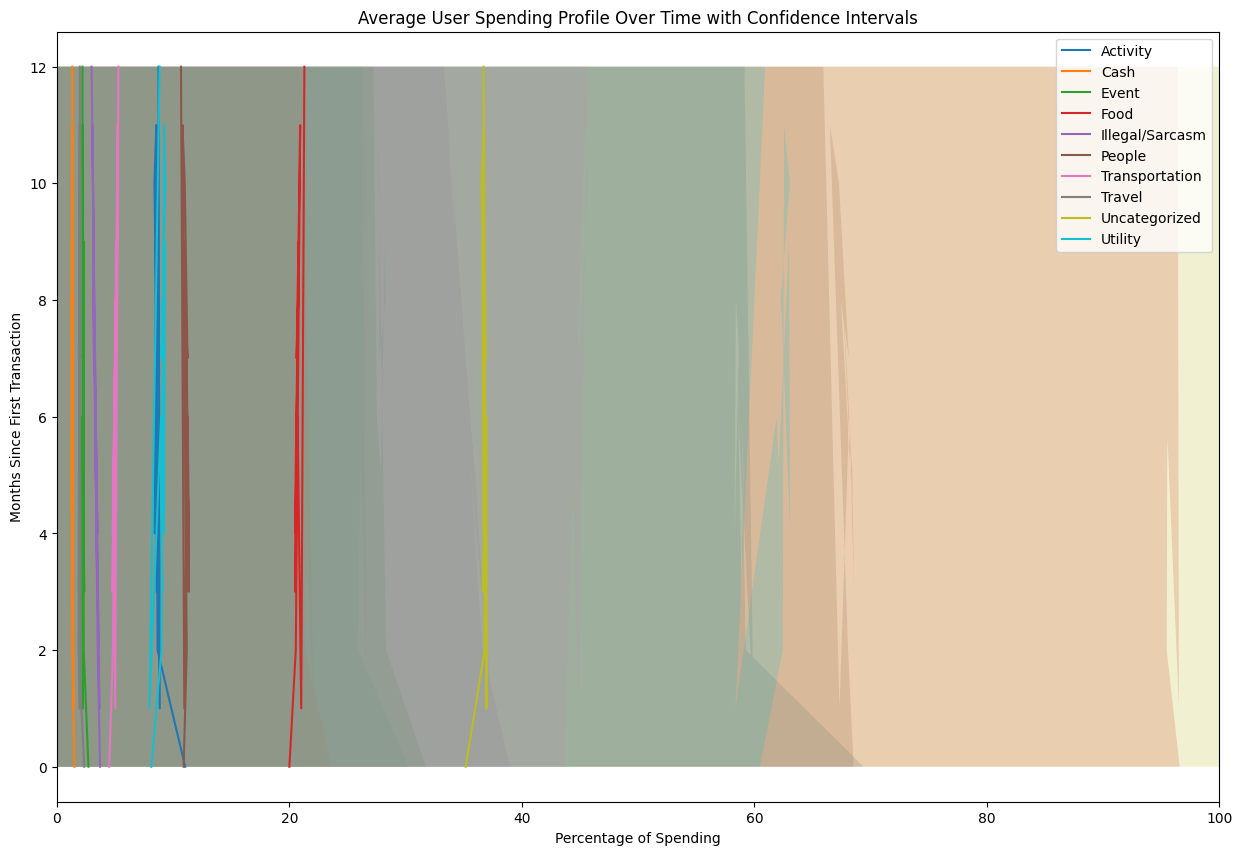

In [ ]:
# Collect the data into Python lists
average_profile_list = average_profile.collect()

# Extract months
months = [row['months_since_first'] for row in average_profile_list]

# Initialize data structures for averages and standard deviations
category_averages = {category: [] for category in list_categories}
category_stddevs = {category: [] for category in list_categories}

# Populate the data structures
for row in average_profile_list:
    for category in list_categories:
        category_averages[category].append(row[f'avg_{category}'])
        category_stddevs[category].append(row[f'std_{category}'])

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

for category in list_categories:
    avg = category_averages[category]
    std = category_stddevs[category]
    ax.plot(avg, months, label=category)
    ax.fill_betweenx(months, np.array(avg) - 2 * np.array(std), np.array(avg) + 2 * np.array(std), alpha=0.2)

ax.set_xlim(0, 100)
ax.set_xlabel('Percentage of Spending')
ax.set_ylabel('Months Since First Transaction')
ax.set_title('Average User Spending Profile Over Time with Confidence Intervals')
ax.legend(loc='best')
plt.show()

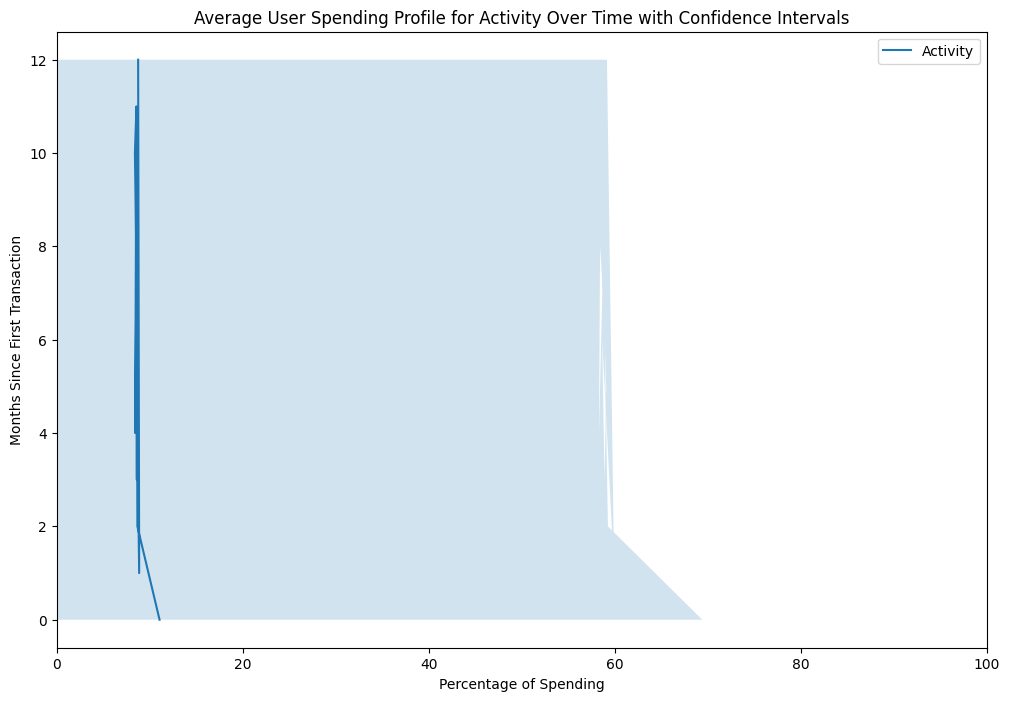

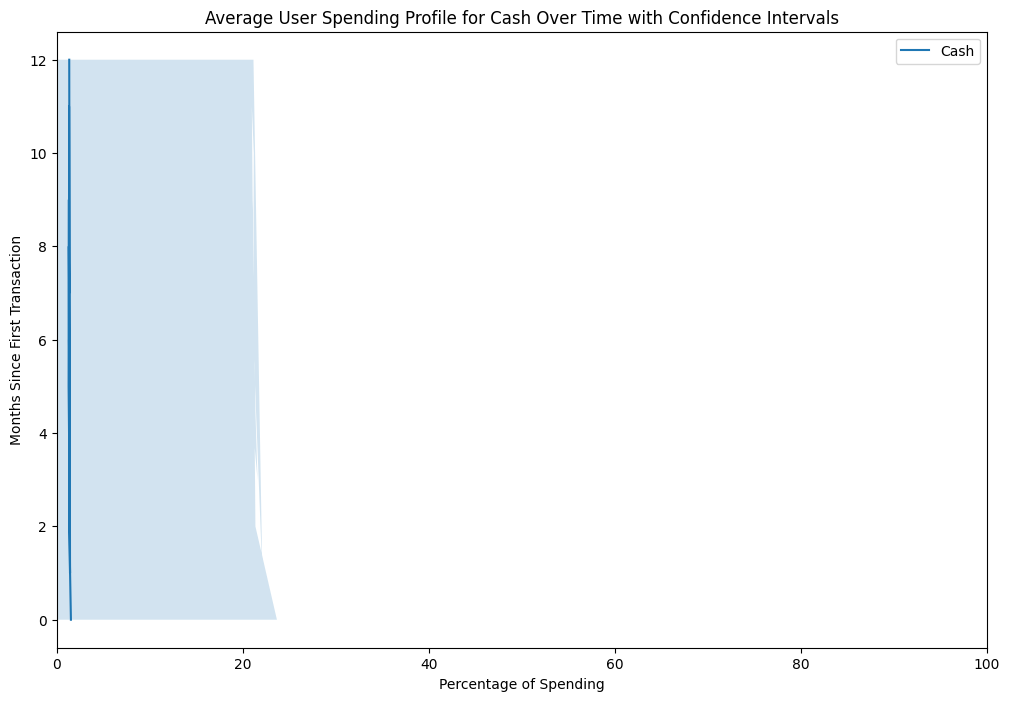

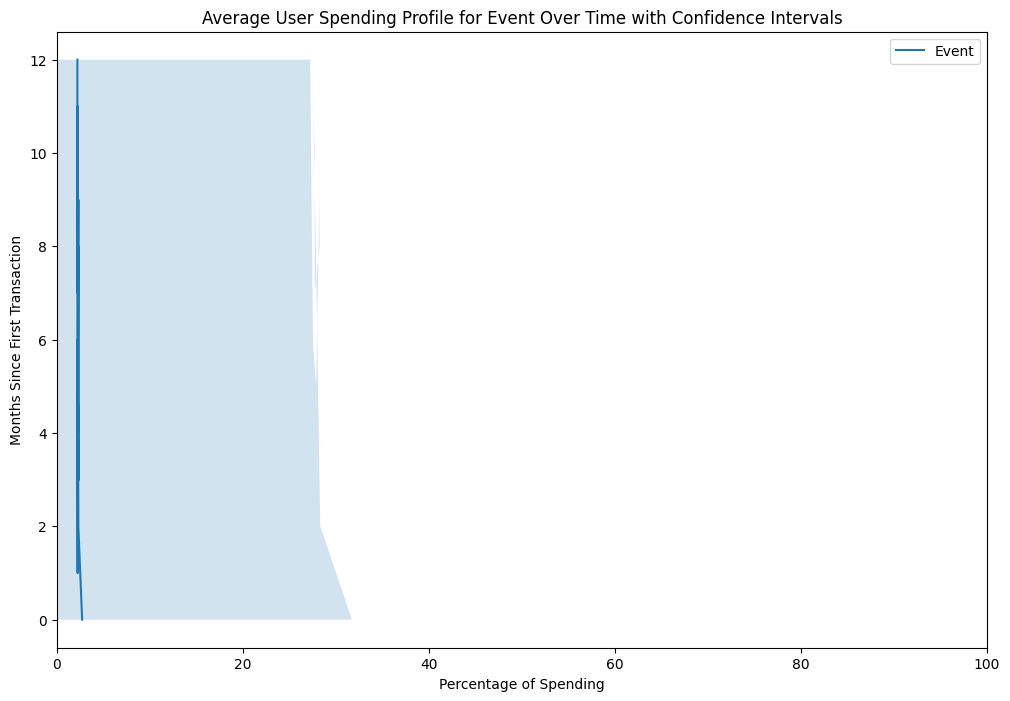

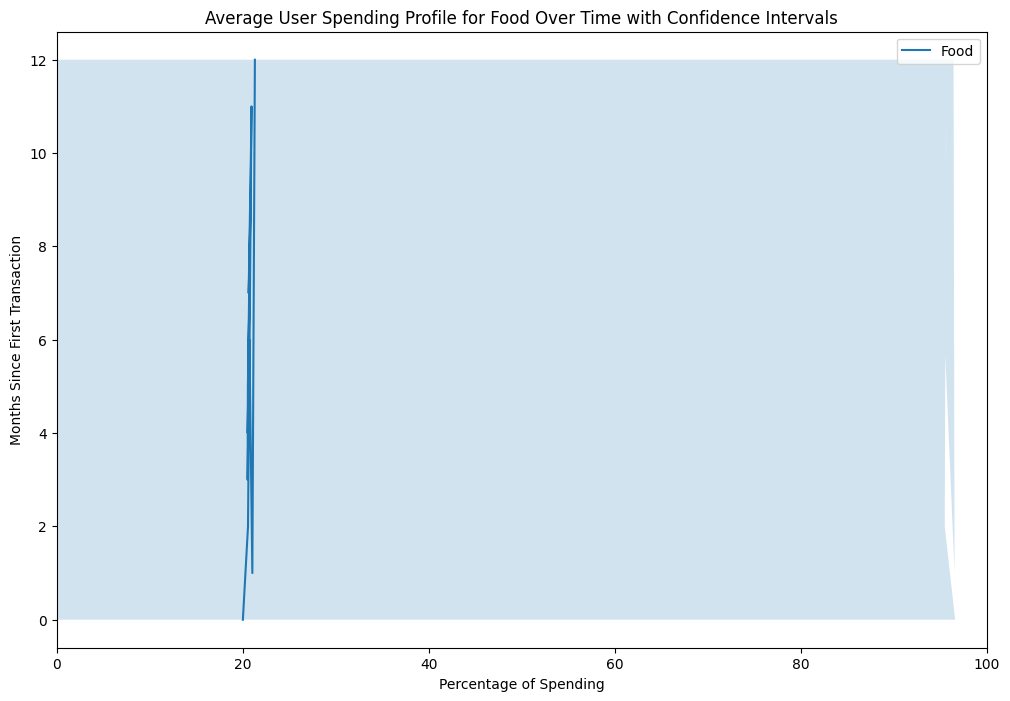

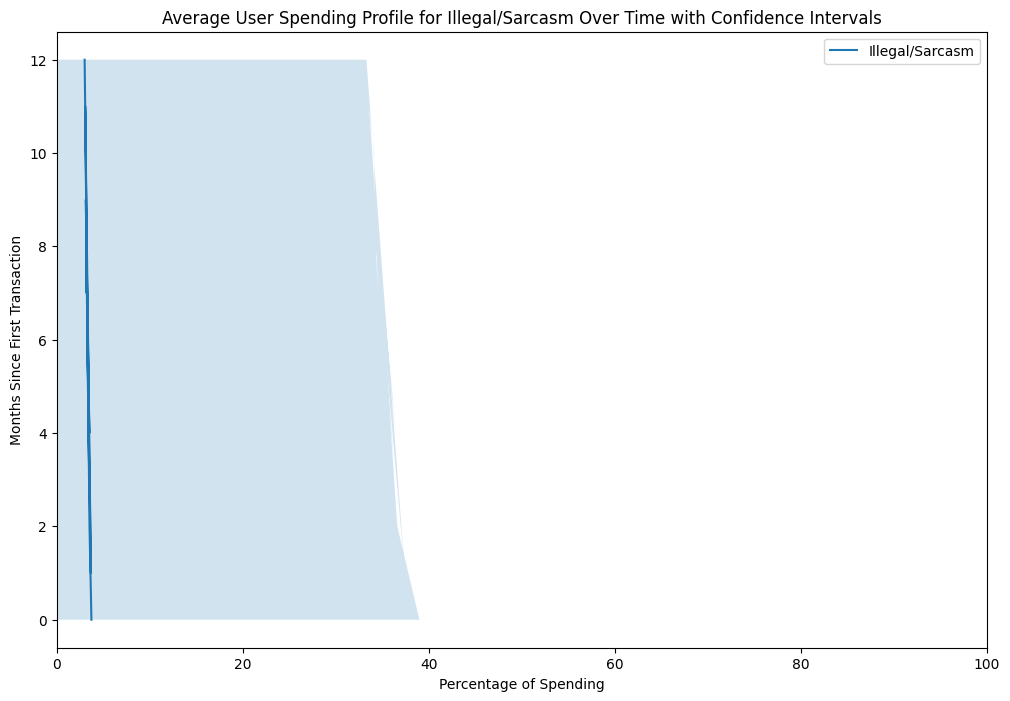

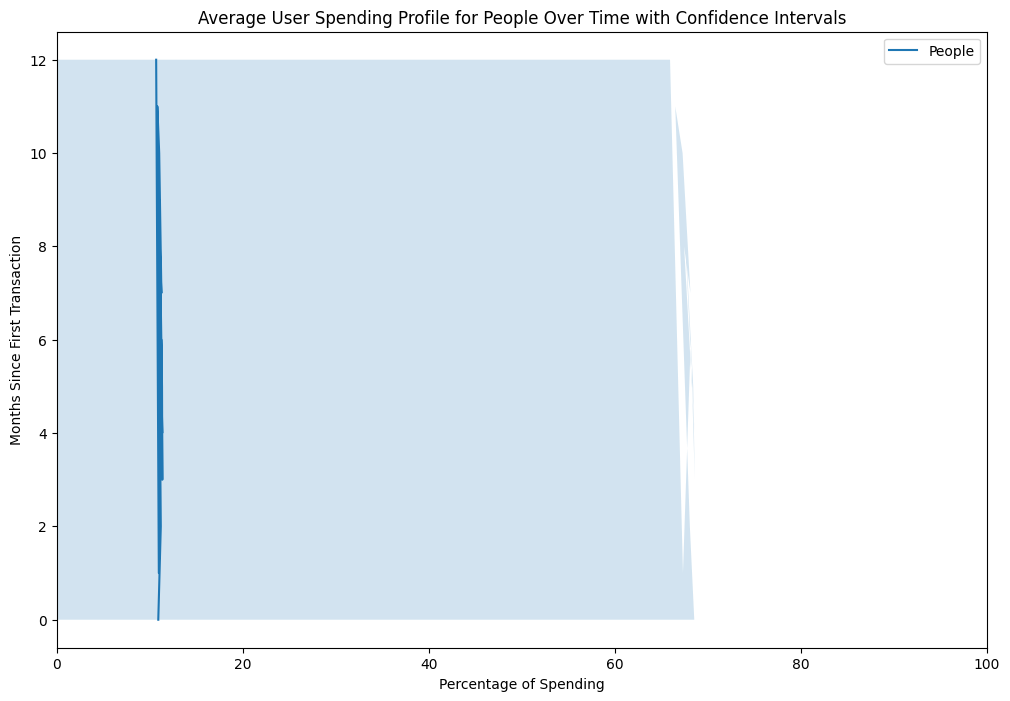

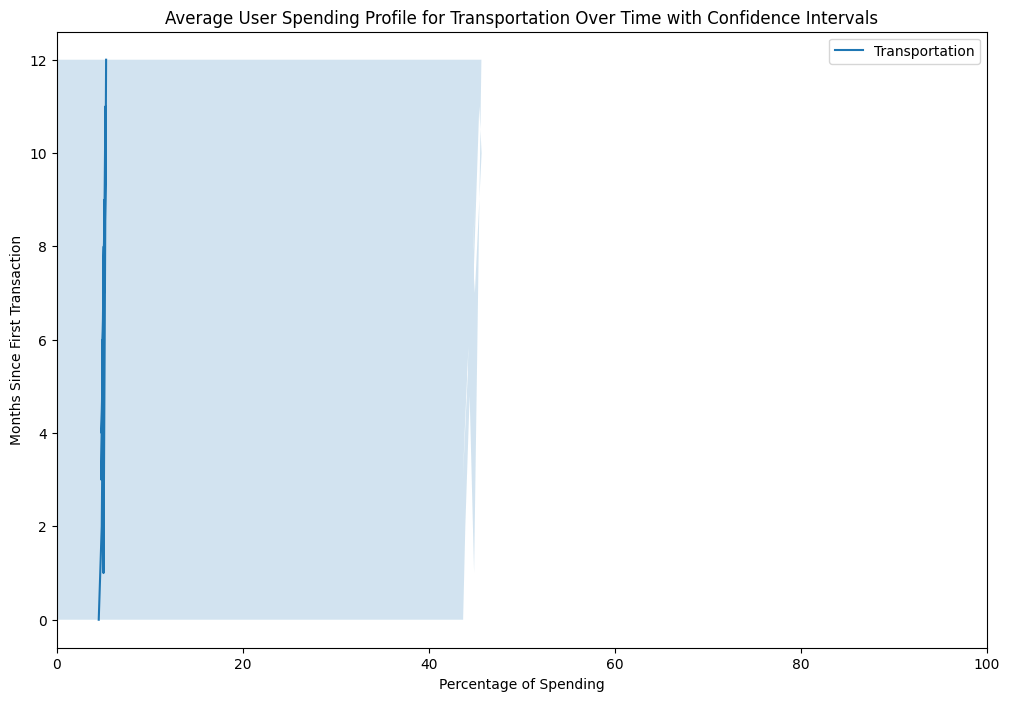

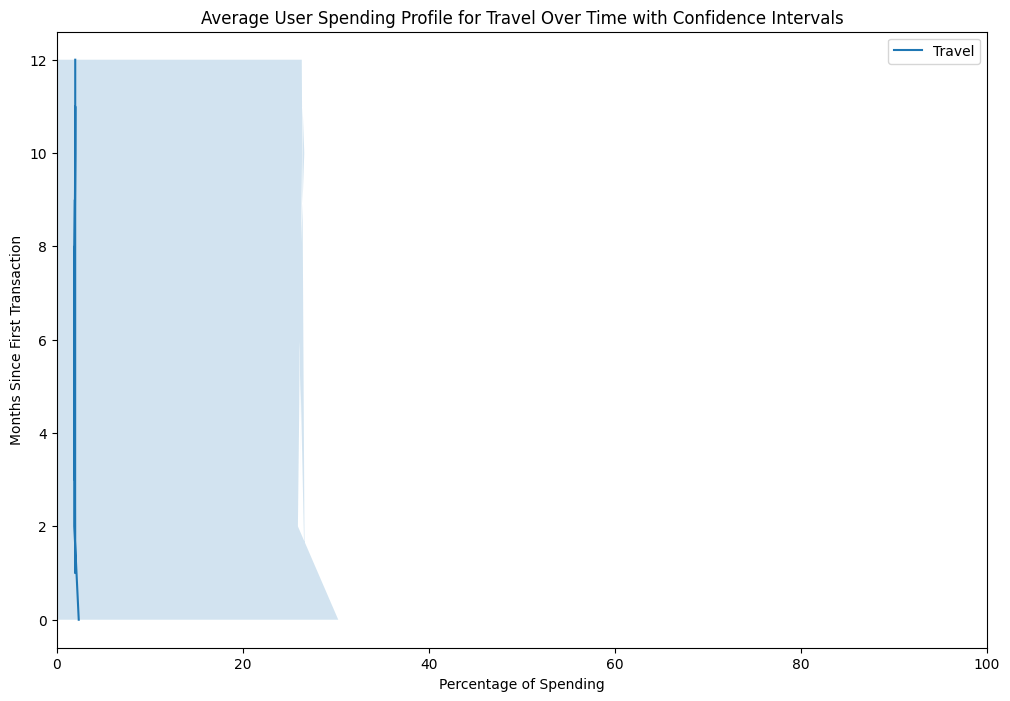

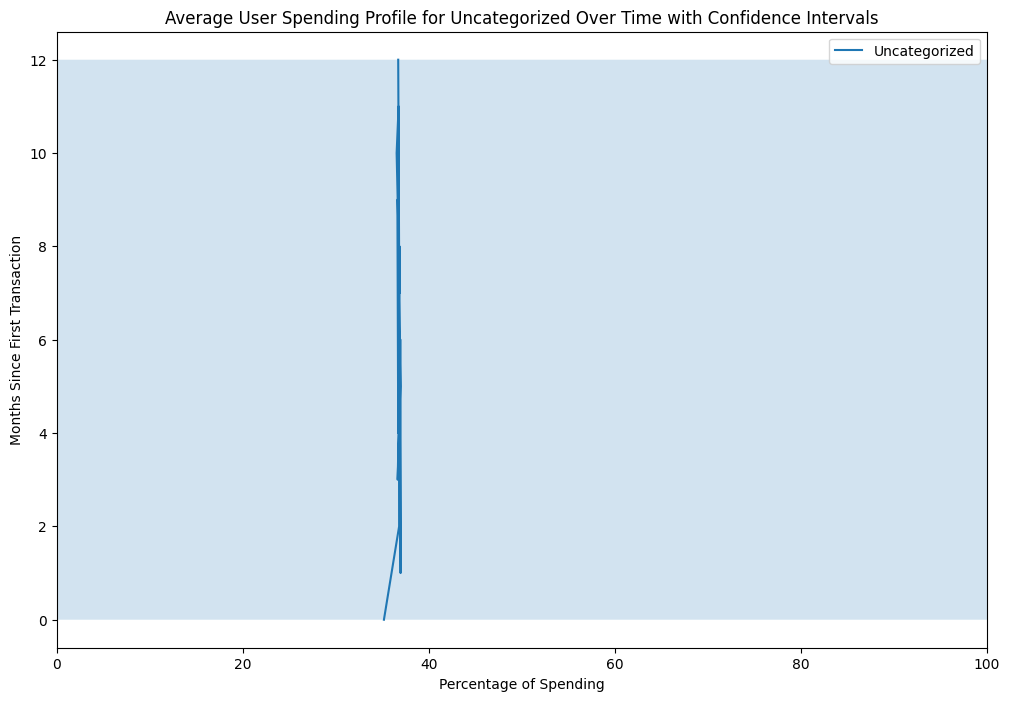

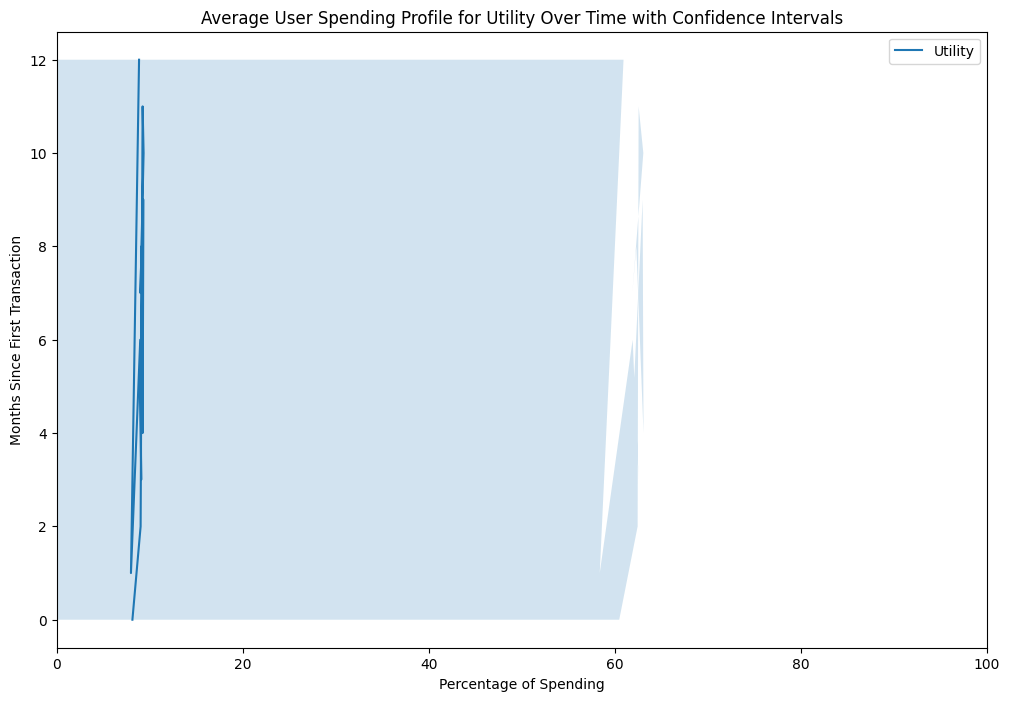

In [ ]:
# Plotting
for category in list_categories:
    fig, ax = plt.subplots(figsize=(12, 8))
    avg = category_averages[category]
    std = category_stddevs[category]
    ax.plot(avg, months, label=category)
    ax.fill_betweenx(months, np.array(avg) - 2 * np.array(std), np.array(avg) + 2 * np.array(std), alpha=0.2)
    ax.set_xlim(0, 100)
    ax.set_xlabel('Percentage of Spending')
    ax.set_ylabel('Months Since First Transaction')
    ax.set_title(f'Average User Spending Profile for {category} Over Time with Confidence Intervals')
    ax.legend(loc='best')
    plt.show()

- Consistent Patterns: Venmo users exhibit stable spending behaviors across 12 months, with average percentages showing little variation.

- Stability Over Time: Spending habits stabilize, indicating users maintain consistent financial behaviors throughout the observed period.

- Long-Term Trends: While minor fluctuations occur, overall spending remains steady.

- Persistent Variability: Categories like "Utility", "Food", "Activity", etc show higher variability, likely due to irregular expenses.

- Influential Factors: External influences may cause slight changes, but users generally maintain consistent financial management through Venmo.

In [ ]:
# Run below commands
!apt-get install openjdk-8-jdk-headless -qq > /dev/null #Install java
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz ## Install Apache Spark
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4081ef029caa8fd206215fe37a6da65d6df47df6d1b7835adf79bd73a4afe41f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import os
from pyspark.sql import SparkSession
# Define Java and Spark home path in Google Colab
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from datetime import datetime, date, timedelta
from dateutil import relativedelta
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.functions import to_timestamp, to_date
from pyspark.sql import functions as F
from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr
from pyspark.sql import DataFrame
import random
from pyspark.sql.window import Window

In [ ]:
# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("RFM in Spark") \
    .getOrCreate()

In [ ]:
# Load the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#To upload files, use the following command
parquet_file_path = '/content/VenmoSample.snappy.parquet'

In [ ]:
# Read the Parquet file
df = spark.read.parquet(parquet_file_path)

# Show the structure of the dataframe - column names , datatypes
df.printSchema()

# displaying the first 5 rows of the data to view the values in each column.
df.show(5)

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af

In [ ]:
df.describe().show()

+-------+------------------+-----------------+----------------+--------------+--------------------+
|summary|             user1|            user2|transaction_type|   description|            story_id|
+-------+------------------+-----------------+----------------+--------------+--------------------+
|  count|           7113137|          7113137|         7113137|       7113137|             7113137|
|   mean|3008165.7137308056| 2922960.93463306|            null|           NaN|            Infinity|
| stddev| 2477181.832091724|2446874.905957469|            null|           NaN|                 NaN|
|    min|                 2|                2|          charge|              |                    |
|    max|          16013547|         16008224|         payment|󾠯󾠷󾠷󾠷󾠷󾠷󾠷|583f159523e064eac...|
+-------+------------------+-----------------+----------------+--------------+--------------------+



In [ ]:
from pyspark.sql.functions import min, max

min_datetime = df.select(min("datetime")).collect()[0][0]
max_datetime = df.select(max("datetime")).collect()[0][0]

print(f"Min datetime: {min_datetime}")
print(f"Max datetime: {max_datetime}")

Min datetime: 2011-11-29 09:21:05
Max datetime: 2016-12-01 02:08:21


In [ ]:
# Total transactions - 7,113,137 between 2011 to 2016
df.count()

7113137

In [ ]:
# Calculate the first transaction date for each user. I'll next use this date for extracting the 1 year user activity
start_dates = df.groupBy("user1").agg(F.min("datetime").alias("start_date"))

# adding the the above calculated start dates to the original dataframe
df_with_start = df.join(start_dates, on="user1")

# Calculate the 12-month end date for each user
df_with_start = df_with_start.withColumn("end_date", F.expr("date_add(start_date, 365)"))

# For each user's, Filter transactions within the first 12 months
df_12_months = df_with_start.filter(
    (df_with_start["datetime"] >= df_with_start["start_date"]) &
    (df_with_start["datetime"] <= df_with_start["end_date"])
)

# Group by user and count the number of transactions within 1st one year
transaction_counts_user = df_12_months.groupBy("user1").agg(F.count("*").alias("transaction_count"))
transaction_counts_user.show()


+-----+-----------------+
|user1|transaction_count|
+-----+-----------------+
|    3|                6|
|   12|                4|
|   13|                4|
|   16|                3|
|   19|                1|
|   28|                1|
|   34|                3|
|   43|               12|
|   47|                1|
|   52|                1|
|  112|                2|
|  126|                2|
|  159|                1|
|  164|                4|
|  192|                1|
|  225|                1|
|  243|                5|
|  332|                1|
|  347|                1|
|  406|                3|
+-----+-----------------+
only showing top 20 rows



In [ ]:
# All the users combined have made - 5,384,292 transaction within their 1st 12 months
df_12_months.count()

5384292

In [ ]:
# Calculate the month number from the start date
df_12_months = df_12_months.withColumn("month_num",F.months_between(F.col("datetime"), F.col("start_date")).cast("int") + 1)

# Define a window specification for partitioning by user and month
window_spec = Window.partitionBy("user1", "month_num").orderBy(F.col("datetime").desc())

# Get the maximum day of the month for each month , so that we can use it later in the code for calculating the recency
df_with_max_day = df_12_months.withColumn("max_day_of_month", F.max(F.dayofmonth(F.col("datetime"))).over(window_spec))

# Calculate recency using the maximum day of the month
df_with_recency = df_with_max_day.withColumn("recency", F.col("max_day_of_month") - F.dayofmonth(F.col("datetime")))

# Calculate recency within each month = last day of month - max day of month
df_with_recency = df_with_recency.withColumn(
    "day_of_month", F.dayofmonth(F.col("datetime"))
).withColumn(
    "last_day_of_month", F.dayofmonth(F.last_day(F.col("datetime"))) #.cast("date")
).withColumn(
    "recency", F.col("last_day_of_month").cast("int") - F.col("max_day_of_month").cast("int")
)

# Calculate the number of transactions (frequency) within each month = for each user , count the no of transactions within each month
df_with_frequency = df_with_recency.groupBy("user1", "month_num").agg(F.count("*").alias("frequency"),F.max("recency").alias("recency"))
df_with_frequency.show(5)

+-----+---------+---------+-------+
|user1|month_num|frequency|recency|
+-----+---------+---------+-------+
|    3|        1|        6|     22|
|   12|        1|        1|     28|
|   12|        5|        1|     17|
|   12|        8|        1|     25|
|   12|       10|        1|     29|
+-----+---------+---------+-------+
only showing top 5 rows



In [ ]:
filtered_df = df_with_frequency.filter(F.col("user1").isin([43, 2824])).groupBy("user1", "month_num").agg(
    F.sum("frequency").alias("total_frequency"),
    F.avg("recency").alias("average_recency")
)
filtered_df.show()

+-----+---------+---------------+---------------+
|user1|month_num|total_frequency|average_recency|
+-----+---------+---------------+---------------+
|   43|        1|              1|           16.0|
|   43|        2|              2|            1.0|
|   43|        3|              1|           10.0|
|   43|        4|              1|            8.0|
|   43|        7|              1|           26.0|
|   43|        8|              1|            1.0|
|   43|        9|              3|           23.0|
|   43|       11|              1|           24.0|
|   43|       12|              1|            0.0|
| 2824|        1|              1|           27.0|
| 2824|        4|              1|            3.0|
| 2824|        5|              1|           19.0|
| 2824|        6|              2|            8.0|
| 2824|        9|              1|           22.0|
+-----+---------+---------------+---------------+



#### **For each user’s lifetime point, regress recency and frequency on Y. Plot the MSE *for* each lifetime point.**

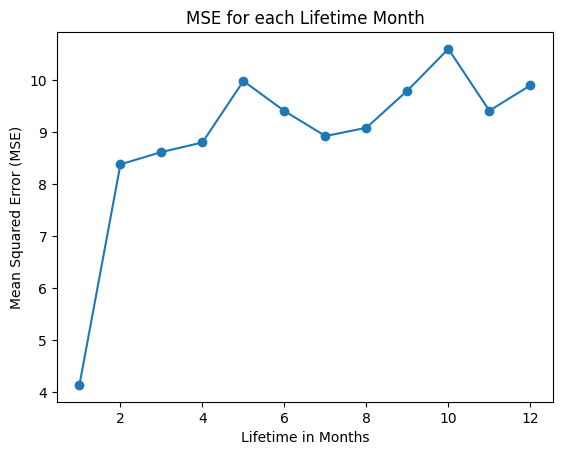

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt

mse_list = []

for month in range(1, 13):
    # Filter the DataFrame for the specific month
    month_df = df_with_frequency.filter(F.col("month_num") == month)

    # Join with the transaction counts to get the target variable
    combined_df = month_df.join(transaction_counts_user, on="user1", how="inner")

    # Split data into training and test sets
    train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

    # Prepare features and label
    assembler = VectorAssembler(inputCols=["frequency", "recency"], outputCol="features")
    train_df = assembler.transform(train_df).select("features", "transaction_count")
    test_df = assembler.transform(test_df).select("features", "transaction_count")

    # Train linear regression model
    lr = LinearRegression(featuresCol="features", labelCol="transaction_count")
    lr_model = lr.fit(train_df)

    # Predict on test data
    predictions = lr_model.transform(test_df)

    # Evaluate model
    evaluator = RegressionEvaluator(labelCol="transaction_count", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)
    mse_list.append(mse)

# Plot MSE for each month
plt.plot(range(1, 13), mse_list, marker='o')
plt.xlabel("Lifetime in Months")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for each Lifetime Month")
plt.show()


In [ ]:
df_with_frequency.count()

4515620

#### **For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y**

In [ ]:
user_monthly_profile_pivot_int = user_monthly_profile_pivot.withColumnRenamed("months_since_first", "month_num")
df_with_frequency = df_with_frequency.join(user_monthly_profile_pivot_int, on=["user1", "month_num"], how="inner")
# df_with_frequency.count()

In [ ]:
mse_list = []

for month in range(1, 13):

    # Filter the DataFrame for the specific month
    month_df = df_with_frequency.filter(F.col("month_num") == month)

    # Join with the transaction counts to get the target variable
    combined_df = month_df.join(transaction_counts_user, on="user1", how="inner")

    # Split data into training and test sets
    train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

    # Prepare features and label
    assembler = VectorAssembler(inputCols=["frequency", "recency", "Activity", "Cash", "Event", "Food", "Illegal/Sarcasm", "People", "Transportation", "Travel", "Uncategorized", "Utility"], outputCol="features")
    train_df = assembler.transform(train_df).select("features", "transaction_count")
    test_df = assembler.transform(test_df).select("features", "transaction_count")

    # Train linear regression model
    lr = LinearRegression(featuresCol="features", labelCol="transaction_count")
    lr_model = lr.fit(train_df)

    # Predict on test data
    predictions = lr_model.transform(test_df)

    # Evaluate model
    evaluator = RegressionEvaluator(labelCol="transaction_count", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)
    mse_list.append(mse)

# Plot MSE for each month
plt.plot(range(1, 13), mse_list, marker='o')
plt.xlabel("Lifetime in Months")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for each Lifetime Month")
plt.show()

In [ ]:
mse_list

#### **For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for each lifetime point like above**

In [ ]:
mse_list = []

for month in range(1, 13):

    # Filter the DataFrame for the specific month
    month_df = results_df.filter(F.col("month_num") == month)

    # Join with the transaction counts to get the target variable
    combined_df = month_df.join(transaction_counts_user, on="user1", how="inner")

    # Split data into training and test sets
    train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

    # Prepare features and label
    assembler = VectorAssembler(inputCols=["number_of_friends", "number_of_friends_of_friends"], outputCol="features")
    train_df = assembler.transform(train_df).select("features", "transaction_count")
    test_df = assembler.transform(test_df).select("features", "transaction_count")

    # Train linear regression model
    lr = LinearRegression(featuresCol="features", labelCol="transaction_count")
    lr_model = lr.fit(train_df)

    # Predict on test data
    predictions = lr_model.transform(test_df)

    # Evaluate model
    evaluator = RegressionEvaluator(labelCol="transaction_count", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)
    mse_list.append(mse)

# Plot MSE for each month
plt.plot(range(1, 13), mse_list, marker='o')
plt.xlabel("Lifetime in Months")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for each Lifetime Month")
plt.show()

#### **For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y. Plot the MSE for each lifetime point like above**

In [ ]:
user_monthly_profile_pivot_int = user_monthly_profile_pivot.withColumnRenamed("months_since_first", "month_num")
results_df = results_df.join(user_monthly_profile_pivot_int, on=["user1", "month_num"], how="inner")


In [ ]:
mse_list = []

for month in range(1, 13):

    # Filter the DataFrame for the specific month
    month_df = results_df.filter(F.col("month_num") == month)

    # Join with the transaction counts to get the target variable
    combined_df = month_df.join(transaction_counts_user, on="user1", how="inner")

    # Split data into training and test sets
    train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

    # Prepare features and label
    assembler = VectorAssembler(inputCols=["number_of_friends", "number_of_friends_of_friends" , "Activity", "Cash", "Event", "Food", "Illegal/Sarcasm", "People", "Transportation", "Travel", "Uncategorized", "Utility"], outputCol="features")
    train_df = assembler.transform(train_df).select("features", "transaction_count")
    test_df = assembler.transform(test_df).select("features", "transaction_count")

    # Train linear regression model
    lr = LinearRegression(featuresCol="features", labelCol="transaction_count")
    lr_model = lr.fit(train_df)

    # Predict on test data
    predictions = lr_model.transform(test_df)

    # Evaluate model
    evaluator = RegressionEvaluator(labelCol="transaction_count", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)
    mse_list.append(mse)

# Plot MSE for each month
plt.plot(range(1, 13), mse_list, marker='o')
plt.xlabel("Lifetime in Months")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for each Lifetime Month")
plt.show()